In [2]:
# Import dependencies

import numpy as np
import pandas as pd
import datetime
import scipy.stats as stats
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from py_vollib.black_scholes.greeks.analytical import delta

The code is copied from https://asxportfolio.com/options-monte-carlo-intro-to-valuing-financial-derivatives



In [33]:
S = 11             #stock price
K = 12             #strike price
vol = 0.2739       # Implied volatility (%) from Black Scholes
r = 0.01           #risk-free rate (%)
N = 365            #number of time steps
M = 1000         #number of simulations
b = 0              #Cost of carry
market_value = 0.48 #market price of option
T = ((datetime.date(2022,6,17)-datetime.date(2021,12,22)).days+1)/365    #time in years


The new drift term has r, the risk free rate, which comes from the need to establish a martingale process. The cost of carry is 0 in my example. this can drop out. $\frac{1}{2} \sigma ^2$ is the extra term in drift term thanks to Ito's Lemma. 

$\nu dt = (r - \delta - 0.5 \sigma ^2) dt $

The process that needs to be simulated becomes:
$ S_{t_i} = exp( x_{t_{i-1}} + \nu \Delta t + \sigma \sqrt{\Delta t} \varepsilon_i ) $

In [34]:
#precompute constants
dt = T/N #Divide the time till maturity to N different steps
nudt = (r - b - 0.5*vol**2)*dt  #the new drift term, b being represented as \delta above
volsdt = vol*np.sqrt(dt) #the new dispersion term, which is the sigma * square root of delta t from above expression
lnS = np.log(S) #natural logarithm of the stock price process 

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) #size N x M matrix of standard normally distributed numbers to be used for \varepsilon_i or error term above 
# Basically, we simulated the random variable for all time steps(N) and all simulation(M) all at once.
delta_lnSt = nudt + volsdt*Z # This is the second and third expression inside the exponential in the formula above, but still in natural log terms.
# delta_lnSt determines the small movement in time
lnSt = lnS + np.cumsum(delta_lnSt, axis=0) #Here, a cumulative sum of changes in paths along the x axis is added(in ln terms) with the initial ln of the price of the underlying.
#all in all, we get the price development in all time steps 

lnSt = np.concatenate( (np.full(shape=(1, M), fill_value=lnS), lnSt ) ) #This line just adds the initial stock price at the beginning of the matrix 
#this will help me when i want to plot the simulated paths.


# Compute Expectation and SE
ST = np.exp(lnSt) # here, we brought the term back to normal by exponentiating again. 
#plotting the matrix shows how the asset price could move  

CT = np.maximum(0, ST - K) # Here, i just want to know the payoff in the final date. it will either be 0 if ST<=K or a positive amount if ST>K
#np.maximum instead of np.max because i am working with array
C0w = np.exp(-r*T)*np.sum(CT[-1])/M # this is just discount factor times sum of all payoffs divided by the number of simulation 
#Once all the payoff are summed in one expression, the question is what is the average payoff over all simulation performed. This is why i divide by M
#then I ask what is the present value of the average payoff. This is why i discount by the risk free rate with continuous discounting. 
# I am working with small horizon so the r can be reasonably assumed to be constant.
sigma = np.sqrt( np.sum( (CT[-1] - C0w)**2) / (M-1) ) # Here, I calculate the sample standard deviation. -+-

SEw = sigma/np.sqrt(M) # and here the standard error

print("Call value is ${0} with SE +/- {1}".format(np.round(C0w,5),np.round(SEw,5)))

Call value is $0.49139 with SE +/- 0.03439


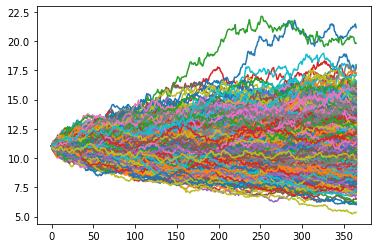

In [35]:
plt.plot(ST) # the price path follows original price scale
#plt.plot(lnst) #this follows the log of the price
#plt.show()

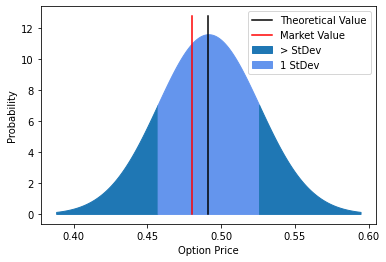

In [36]:
#x1, x2, and x3 is defining the space between 3 standard deviation left and right of the true value C0w and dividing them from the 
x1 = np.linspace(C0w-3*SEw, C0w-1*SEw, 100) # from -3 to -1
x2 = np.linspace(C0w-1*SEw, C0w+1*SEw, 100) #from -1 to +1
x3 = np.linspace(C0w+1*SEw, C0w+3*SEw, 100) #from +1 to +3 standard deviation

#s1, s2, and s3 sets the boundaries
s1 = stats.norm.pdf(x1, C0w, SEw) 
s2 = stats.norm.pdf(x2, C0w, SEw)
s3 = stats.norm.pdf(x3, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev') # this here is left part which is bigger than 1 standard deviation 
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev') # this is 1 standard deviation left and right of the average value calculated by the model 
plt.fill_between(x3, s3, color='tab:blue') #this here is right part which is bigger than 1 standard deviation

plt.plot([C0w,C0w],[0, max(s2)*1.1], 'k', label='Theoretical Value') #black line plots the theoretical value
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r', label='Market Value') # red line plots the market price

plt.ylabel("Probability") # show the y- axis label
plt.xlabel("Option Price") # show the x- axis label
plt.legend() # show the legend
plt.show() #show the plot

#if the red line is within cornflower blue, or 1 standard deviation, the price is well within expectation.

In [38]:
N = 365
dt = T/N
nudt = (r- 0.5*vol*vol)*dt
volsdt = vol*np.sqrt(dt)
lnS = np.log(S)

Z = np.random.normal(size=(N,M))
delta_lnSt1 = nudt + volsdt * Z
delta_lnSt2 = nudt - volsdt * Z

lnSt1 = lnS + np.cumsum(delta_lnSt1, axis=0)
lnSt2 = lnS + np.cumsum(delta_lnSt2, axis=0)

ST1 = np.exp(lnSt1)
ST2 = np.exp(lnSt2)

CT = 0.5*(np.maximum(0, ST1[-1] - K)+ np.maximum(0, ST2[-1] - K) )
C0 = np.exp(-r*T) *np.sum(CT) / M

sigma = np.sqrt (np.sum((CT-C0)**2)/(M-1))
SE = sigma / np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,5),np.round(SE,5)))

Call value is $0.4752 with SE +/- 0.02089


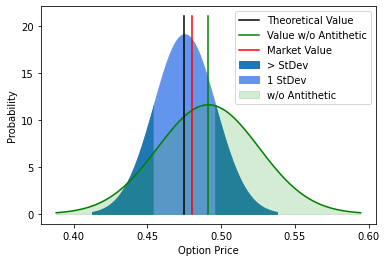

In [39]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Antithetic')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k', label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='g', label='Value w/o Antithetic')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r', label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()

In [40]:
def delta_calc(r, S, K, T, sigma, type="c"):
    "Calculate delta of an option"
    d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))
    try:
        if type == "c":
            delta_calc = stats.norm.cdf(d1, 0, 1)
        elif type == "p":
            delta_calc = -stats.norm.cdf(-d1, 0, 1)
        return delta_calc
    except:
        print("Please confirm option type, either 'c' for Call or 'p' for Put!")

In [42]:
#Control Variates variance reduction method.

N = 365
dt = T/N
nudt = (r - 0.5*vol**2)*dt
volsdt = vol*np.sqrt(dt)

erdt = np.exp(r*dt)
cv = 0
beta1 = -1

# Monte Carlo Method
Z = np.random.normal(size=(N, M)) 
delta_St = nudt + volsdt*Z
ST = S*np.cumprod( np.exp(delta_St), axis=0)
ST = np.concatenate( (np.full(shape=(1, M), fill_value=S), ST ) ) #add the initial price to the start of the matrix
deltaSt = delta_calc(r, ST[:-1].T, K, np.linspace(T,0,N), vol, "c").T
cv = np.cumsum(deltaSt*(ST[1:] - ST[:-1]*erdt), axis=0)


CT = np.maximum(0, ST[-1] - K) + beta1*cv[-1]
# CT = np.maximum(0, ST[-1] - K)
C0 = np.exp(-r*T)*np.sum(CT)/M

sigma = np.sqrt( np.sum( (np.exp(-r*T)*CT - C0)**2) / (M-1) )
sigma = np.std(np.exp(-r*T)*CT)
SE = sigma/np.sqrt(M)

print("Call value is ${0} with SE +/- {1}".format(np.round(C0,5),np.round(SE,5)))

Call value is $0.48279 with SE +/- 0.00125


/var/folders/bj/4zc2llw15wx0r_qn518t1vwr0000gn/T/ipykernel_73785/1824272541.py:3: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (np.log(S/K) + (r + sigma**2/2)*T)/(sigma*np.sqrt(T))


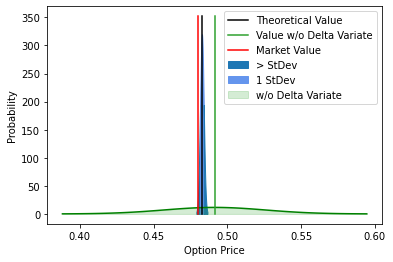

In [43]:
x1 = np.linspace(C0-3*SE, C0-1*SE, 100)
x2 = np.linspace(C0-1*SE, C0+1*SE, 100)
x3 = np.linspace(C0+1*SE, C0+3*SE, 100)
xw = np.linspace(C0w-3*SEw, C0w+3*SEw, 100)

s1 = stats.norm.pdf(x1, C0, SE)
s2 = stats.norm.pdf(x2, C0, SE)
s3 = stats.norm.pdf(x3, C0, SE)
sw = stats.norm.pdf(xw, C0w, SEw)

plt.fill_between(x1, s1, color='tab:blue',label='> StDev')
plt.fill_between(x2, s2, color='cornflowerblue',label='1 StDev')
plt.fill_between(x3, s3, color='tab:blue')
plt.plot(xw, sw, 'g-')
plt.fill_between(xw, sw, alpha=0.2, color='tab:green', label='w/o Delta Variate')

plt.plot([C0,C0],[0, max(s2)*1.1], 'k', label='Theoretical Value')
plt.plot([C0w,C0w],[0, max(s2)*1.1], color='tab:green', label='Value w/o Delta Variate')
plt.plot([market_value,market_value],[0, max(s2)*1.1], 'r', label='Market Value')

plt.ylabel("Probability")
plt.xlabel("Option Price")
plt.legend()
plt.show()


In [64]:
#Sidestep as to how the implied volatility was calculated
# code copied from https://kevinpmooney.blogspot.com/2017/07/calculating-implied-volatility-from.html
from scipy.stats import norm
from math import sqrt, exp, log, pi

def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * sqrt(t)) * ( log(S/K) + (r + sigma**2/2) * t)
    d2 = d1 - sigma * sqrt(t)
    return d1, d2

def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * exp(-r * t)
    return C

#  S  = Stock price
#  K  = strike
#  C  = price of call as predicted by Black-Scholes model
#  r  = risk-free interest rate
#  t  = time to expiration expressed in years
#  C0 = price of call option from option chain

S = 11
K = 12
r = 0.01
t = 177.0/365.0
C0 = 0.48

#  We need a starting guess for the implied volatility.  We chose 0.5
#  arbitrarily.
vol = 0.9


epsilon = 1.0          #  Define variable to check stopping conditions
abstol = 1e-4          #  Stop calculation when abs(epsilon) < this number

count = 0                  #  Variable to count number of iterations
max_iter = 1e3         #  Max number of iterations before aborting

while epsilon > abstol:
    count +=1
    #  if-statement to avoid getting stuck in an infinite loop.
    if count > max_iter:
        print ("Program failed to find a root.  Exiting.")
        break

    orig_vol = vol
    d1, d2 = d(vol, S, K, r, t)
    function_value = call_price(vol, S, K, r, t, d1, d2) - C0
    vega = S * norm.pdf(d1) * sqrt(t)
    vol = -function_value/vega + vol
    #epsilon = abs(function_value)
    epsilon = abs((vol - orig_vol) / orig_vol)

print ('Implied volatility = ',  vol)
print ('Code required', count, 'iterations.')



Implied volatility =  0.27393611030853965
Code required 3 iterations.
